In [129]:
import feedparser
import pandas as pd
import numpy as np
import sqlite3
import sqlalchemy
import calendar
from salesman import scrape_craigslist, describe, expected_price
from craigslist_scraper import scraper
from skimage import io
from geopy.distance import geodesic
import re
import logging
from IPython.core.display import display, HTML
import ipywidgets as widgets

In [208]:

logging.basicConfig()

logger = logging.getLogger("db")


logger.setLevel(logging.INFO)

logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING) 

# Improvements
 - move more to modules
 - ability to delete
 - better url links
 - understand errors we're hitting
 - add python logging
 - better SQL interaction, use ORM more

In [209]:
# TODO: https://www.tutorialspoint.com/sqlalchemy/sqlalchemy_core_creating_table.htm
TABLE_SQL = """
CREATE TABLE IF NOT EXISTS craigslist_cars (
    id integer PRIMARY KEY,
    region text NOT NULL,
    url text NOT NULL UNIQUE,
    title text,
    price integer,
    odometer integer,
    new_price integer,
    make text,
    model text,
    year integer,
    published integer,
    deleted integer default 0,
    distance real
); 
"""

DB = 'rss.db'
HOME_COORS = (42.126509, -71.35252)

In [210]:
class DeleteButton(widgets.Button):
    def __init__(self, engine, output, url=None, **kwargs):
        super().__init__(**kwargs)
        self.engine = engine
        self.url = url
        self.on_click(self.delete)
        self.description = 'Delete Entry'
        self.output = output
        
    def delete(self, b):
        print("delete")

        delete_sql = f"""
            UPDATE craigslist_cars
            SET deleted = 1
            WHERE url = '{self.url}'; 
        """
        
        with self.engine.connect() as connection:
            connection.execute(delete_sql)
        
        with self.output:
            print(f"Marked {self.url} as deleted")
            
        self.description = 'Restore Entry'
        self.on_click(self.delete, remove=True)
        self.on_click(self.restore)
            
    def restore(self, b):
        print("RESTORE")
        restore_sql = f"""
            UPDATE craigslist_cars
            SET deleted = 0
            WHERE url = '{self.url}'; 
        """
        
        with self.engine.connect() as connection:
            connection.execute(restore_sql)
        
        with self.output:
            print(f"Marked {self.url} as not deleted")
        
        self.description = 'Delete Entry'
        self.on_click(self.restore, remove=True)
        self.on_click(self.delete)


In [211]:
def get_old_rss_feed():
    # defaults, can move to args
    make = 'subaru'
    model = 'forester'
    miles = [1_000, 100_000]
    years = [2000, 2008]
    price = [3_000, 27_000]
    
    # search region
    region = 'boston'
    zipcode = '02056'
    radius = 150
    
    # construct rss url
    rss = f"https://{region}.craigslist.org/search/cta?&format=rss"
    rss += f"&postal={zipcode}"
    rss += f"&search_distance={radius}"
    rss += f"&auto_make_model={make}%20{model}"
    rss += f"&max_auto_miles={miles[1]}"
    rss += f"&max_auto_year={years[1]}"
    rss += f"&max_price={price[1]}"
    rss += f"&min_auto_miles={miles[0]}"
    rss += f"&min_auto_year={years[0]}"
    rss += f"&min_price={price[0]}"
    
    # get rss feed
    feed = feedparser.parse(rss)
    
    return make, model, feed['entries']

def get_new_rss_feed():
    # defaults, can move to args
    make = 'subaru'
    model = 'forester'
    miles = [1_000, 35_000]
    years = [2017, 2021]
    price = [3_000, 27_000]
    
    # search region
    region = 'boston'
    zipcode = '02056'
    radius = 150
    
    # construct rss url
    rss = f"https://{region}.craigslist.org/search/cta?&format=rss"
    rss += f"&postal={zipcode}"
    rss += f"&search_distance={radius}"
    rss += f"&auto_make_model={make}%20{model}"
    rss += f"&max_auto_miles={miles[1]}"
    rss += f"&max_auto_year={years[1]}"
    rss += f"&max_price={price[1]}"
    rss += f"&min_auto_miles={miles[0]}"
    rss += f"&min_auto_year={years[0]}"
    rss += f"&min_price={price[0]}"
    
    # get rss feed
    feed = feedparser.parse(rss)
    
    return make, model, feed['entries']

In [212]:
def row_from_entry(e, make, model):
    url = e['link']
    miles, price, _ = scrape_craigslist(url)
    
    cl = scraper.scrape_url(url)
    position = cl.soup.find('meta', attrs={"name":'geo.position'})['content']
    car_coords = tuple(map(float, position.split(';')))
    distance = geodesic(HOME_COORS, car_coords).miles
    
    regex = re.search(r'(20\d\d)', e['title'])
    
    if regex is None:
        year = None
    else:
        year = int(regex.group())
    
    df = pd.DataFrame([{
        #'id': None,
        'region': url[8:].split('.')[0],
        'url': url,
        'title': e['title'],
        'price': price,
        'odometer': miles,
        'new_price': np.NaN,
        'make': make,
        'model': model,
        'year': year,
        'published': calendar.timegm(e['published_parsed']),
        'deleted': 0,
        'distance': distance
    }])
    
    return df
    
def insert_post(df):
    try:
        conn = sqlite3.connect(DB)
        df.to_sql('craigslist_cars', con=conn, if_exists='append', index=False)
        conn.close()
    except sqlite3.IntegrityError as e:
        if 'UNIQUE constraint failed' in e.args[0]:
            logger.debug('Duplicate Entry')
        else:
            raise RuntimeError(f"Unknown error: {e}")
    finally:
        conn.close()

    

In [213]:
# create table if it doesn't exist
#conn = sqlite3.connect(DB)
#c = conn.cursor()
#c.execute(TABLE_SQL)
#conn.close()

In [214]:
make, model, entries = get_new_rss_feed()

logger.info(f"Found {len(entries)} results.")
engine = sqlalchemy.create_engine('sqlite:///rss.db', connect_args={'timeout': 15})

for post in entries:
    url = post['id']
    
    with engine.connect() as connection:
        result = connection.execute(f"SELECT COUNT(*) FROM craigslist_cars WHERE url = '{url}'")
        exists = result.scalar() > 0

    if exists:
        logger.info("Skipping existing result")
        logger.debug(f"Already logged {url}")
        continue

    logger.info(url)
    
    try:
        df =  row_from_entry(post, make, model)
        insert_post(df)
    except Exception as e:
        logger.error(f"{e}")

INFO:db:Found 21 results.
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result


In [215]:
make, model, entries = get_old_rss_feed()

logger.info(f"Found {len(entries)} results.")
engine = sqlalchemy.create_engine('sqlite:///rss.db', connect_args={'timeout': 15})

for post in entries:
    url = post['id']
    
    with engine.connect() as connection:
        result = connection.execute(f"SELECT COUNT(*) FROM craigslist_cars WHERE url = '{url}'")
        exists = result.scalar() > 0

    if exists:
        logger.info("Skipping existing result")
        logger.debug(f"Already logged {url}")
        continue

    logger.info(url)
    
    try:
        df =  row_from_entry(post, make, model)
        insert_post(df)
    except Exception as e:
        logger.error(f"{e}")

INFO:db:Found 7 results.
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result
INFO:db:Skipping existing result


DEBUG:db:too expensive at 23995 - 3395.0 added
DEBUG:db:cached
DEBUG:db:cached
INFO:db:Looks good: https://capecod.craigslist.org/cto/d/marstons-mills-2018-subaru-forester-25i/7170096108.html


DeleteButton(description='Delete Entry', style=ButtonStyle())

Output()

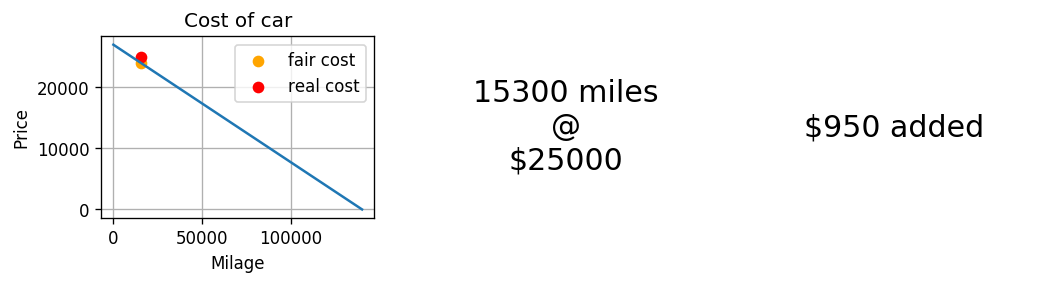

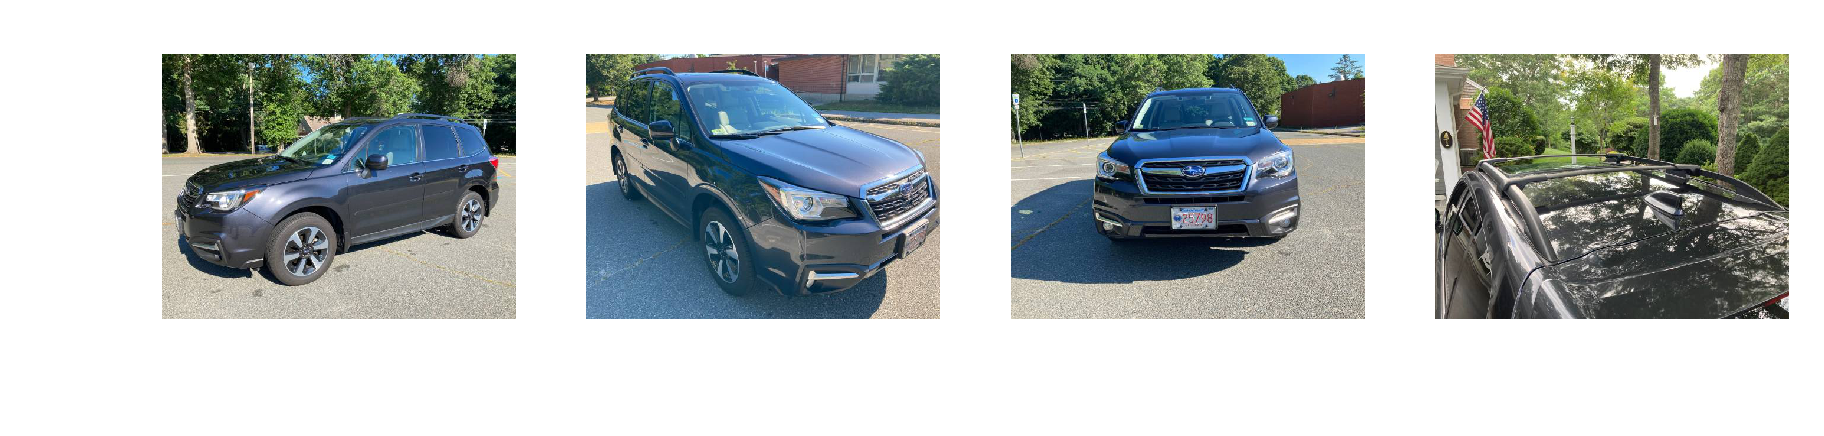

INFO:db:Looks good: https://boston.craigslist.org/nos/ctd/d/manchester-2017-subaru-forester-one/7159974857.html


DeleteButton(description='Delete Entry', style=ButtonStyle())

Output()

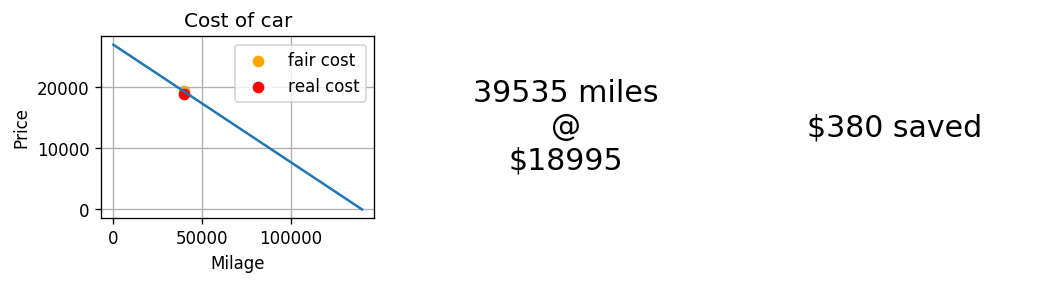

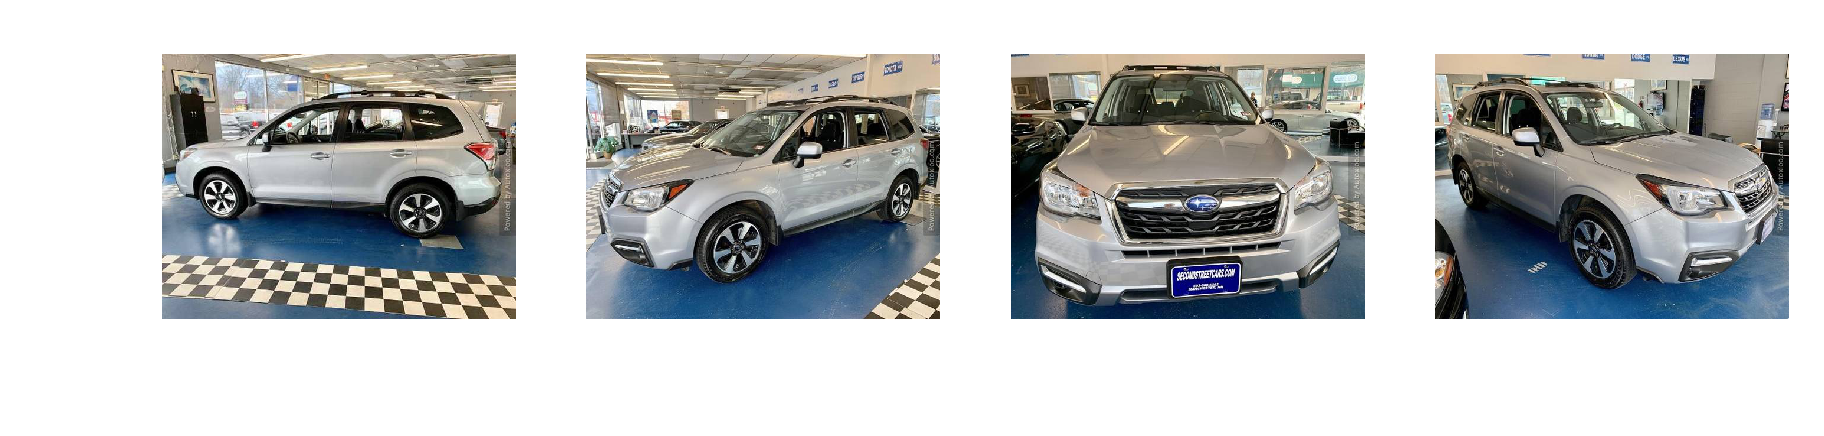

ERROR:db:list index out of range - https://westernmass.craigslist.org/ctd/d/ashuelot-subaru-18-forester-limited-13k/7156733620.html
DEBUG:db:cached
DEBUG:db:cached
ERROR:db:list index out of range - https://vermont.craigslist.org/ctd/d/vernon-subaru-18-forester-limited-13k/7156732145.html
ERROR:db:list index out of range - https://vermont.craigslist.org/ctd/d/vernon-subaru-2017-forester-21k-ac-pw/7156953435.html
ERROR:db:list index out of range - https://westernmass.craigslist.org/ctd/d/vernon-subaru-2017-forester-21k-auto-pw/7156953853.html
DEBUG:db:rebuilt
DEBUG:db:cached
DEBUG:db:rebuilt
DEBUG:db:cached
DEBUG:db:cached
DEBUG:db:cached
DEBUG:db:cached
DEBUG:db:cached
DEBUG:db:cached
DEBUG:db:cached
INFO:db:Looks good: https://maine.craigslist.org/ctd/d/winnisquam-2017-subaru-forester-25/7165836129.html


DeleteButton(description='Delete Entry', style=ButtonStyle())

Output()

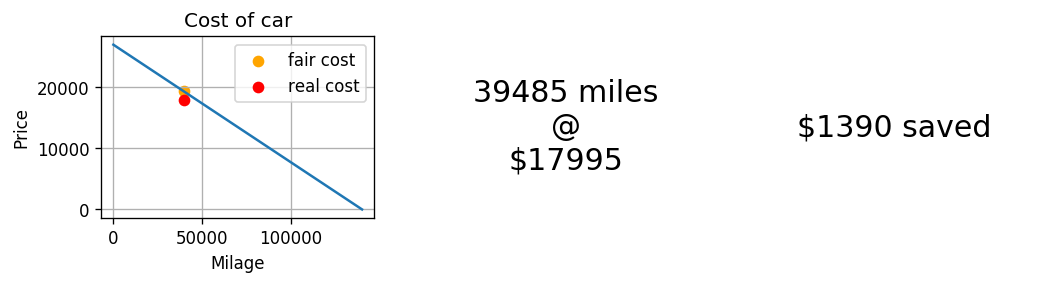

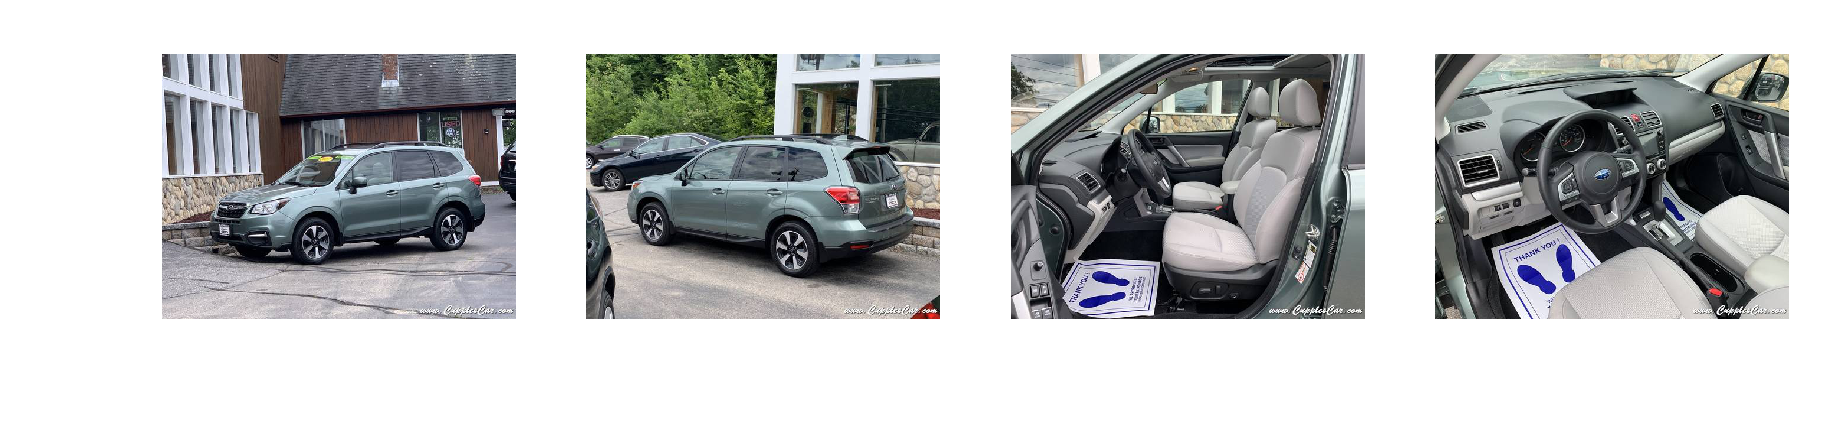

DEBUG:db:cached
DEBUG:db:cached
INFO:db:Looks good: https://newhaven.craigslist.org/ctd/d/norwalk-2017-subaru-forester-25i-premium/7173065625.html


DeleteButton(description='Delete Entry', style=ButtonStyle())

Output()

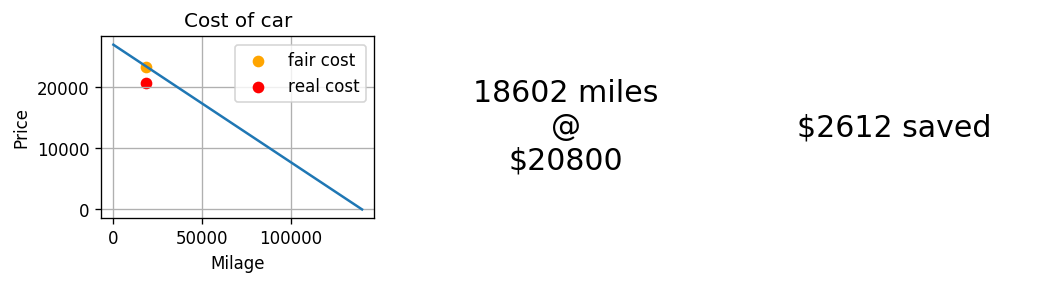

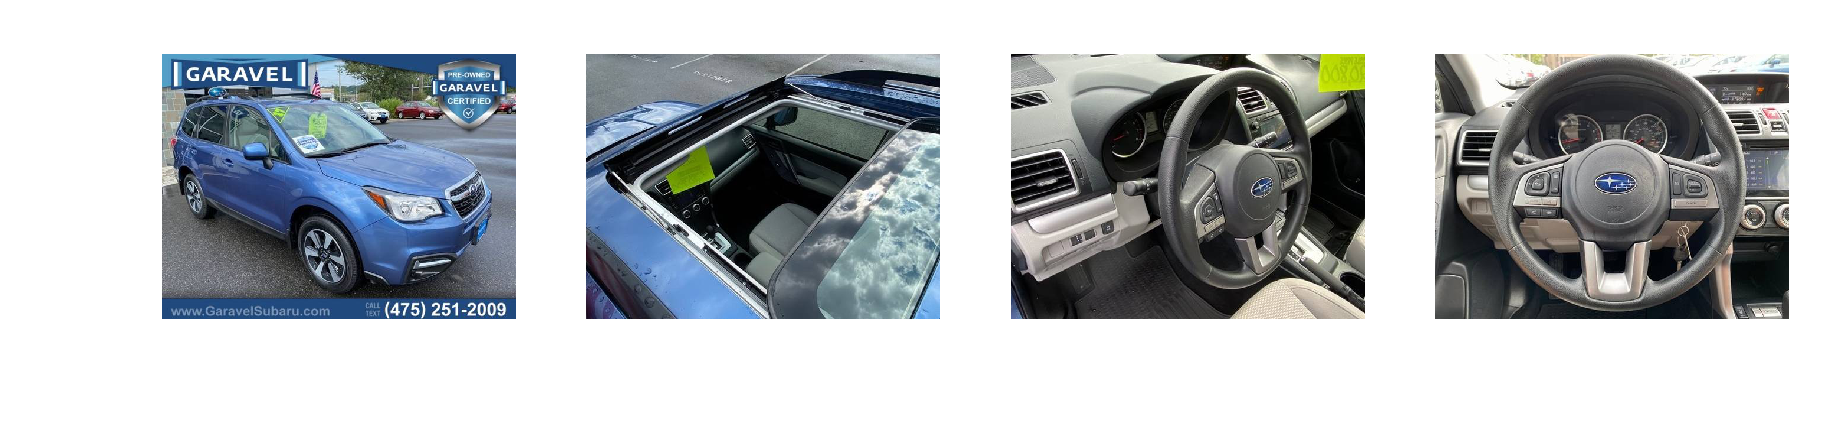

DEBUG:db:cached
DEBUG:db:too expensive at 25500 - 2100.0 added
DEBUG:db:rebuilt
DEBUG:db:rebuilt
DEBUG:db:cached
DEBUG:db:cached
DEBUG:db:cached
DEBUG:db:too expensive at 19995 - 1300.7999999999993 added
DEBUG:db:rebuilt
INFO:db:Looks good: https://vermont.craigslist.org/cto/d/randolph-2018-subaru-forester-only-miles/7174977116.html


DeleteButton(description='Delete Entry', style=ButtonStyle())

Output()

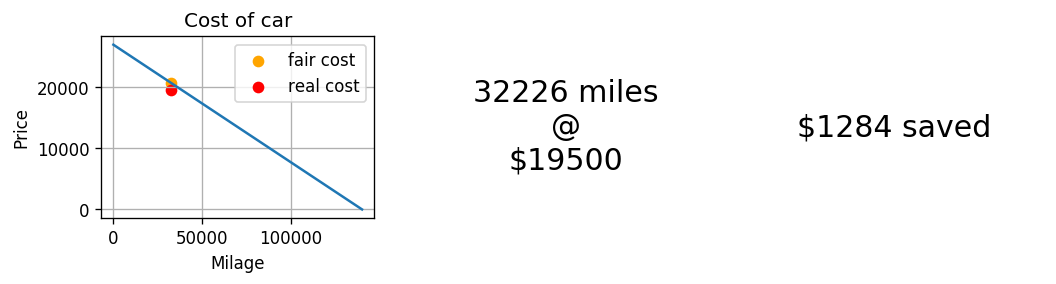

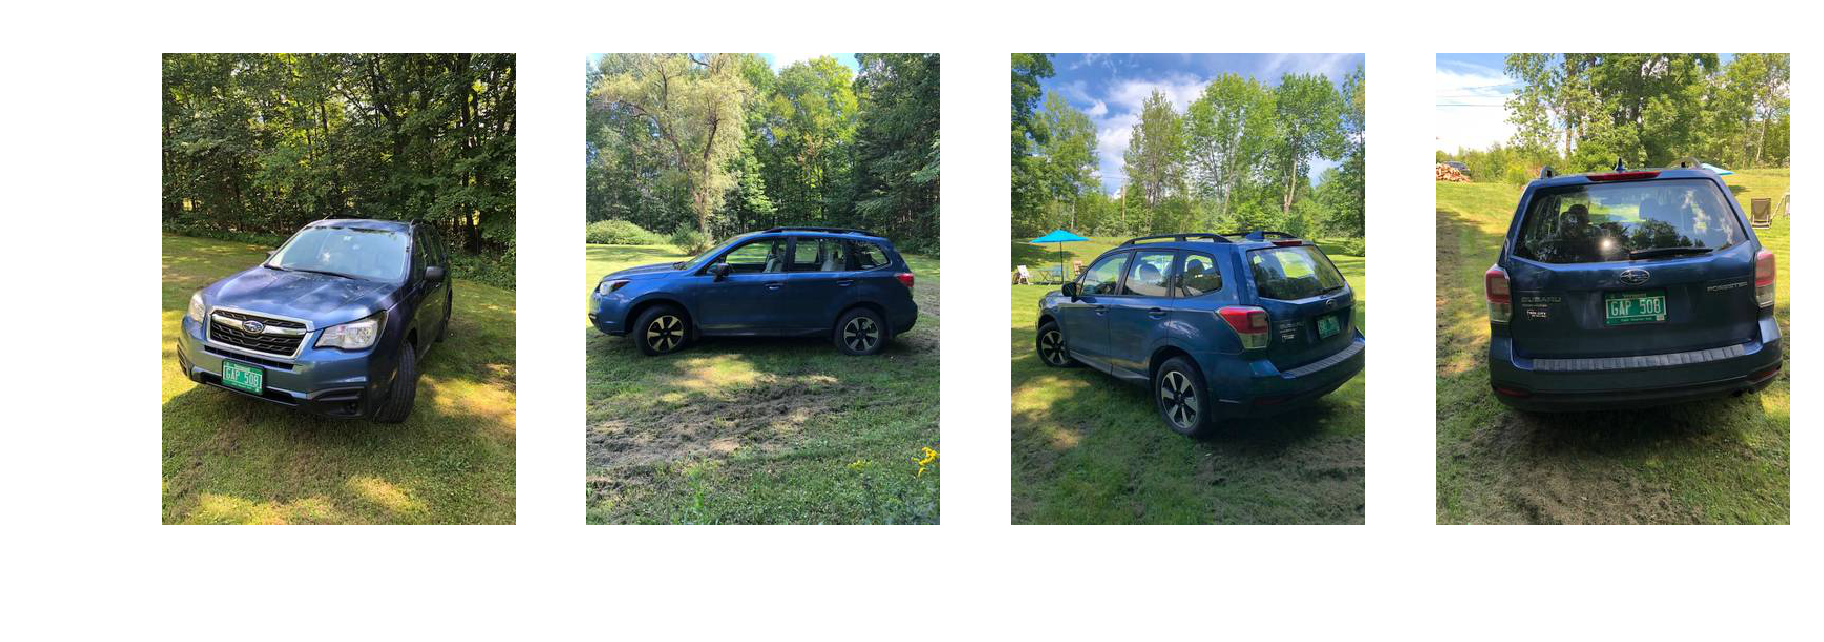

DEBUG:db:too expensive at 21400 - 914.2000000000007 added
DEBUG:db:too expensive at 23950 - 11049.6 added


In [191]:
QUERY = """
    SELECT url, price, odometer
    FROM craigslist_cars
    WHERE year > 2016
      AND price < 26000
      AND deleted <> 1
"""

with engine.connect() as connection:
    results = connection.execute(QUERY).fetchall()
    
posted_urls = set()

for res in results:
    url, price, miles = res
    
    # check for repeats
    key = "/".join(url.split('/')[-2])
    if key in posted_urls:
        logger.debug('cached')
        continue
    else:
        posted_urls.add(key)
    
    # check if price too much
    if price > expected_price(28_000, miles) + 500:
        logger.debug(f"too expensive at {price} - {price - expected_price(28_000, miles)} added")
        continue
        
    # display 
    try:

        cl = scraper.scrape_url(url)
        if cl.attrs['title status'] == 'rebuilt':
            logger.debug("rebuilt")
            continue
        
        logger.info(f"Looks good: {url}")

        # link
        display(HTML(f"""<a href="{url}">{url}</a>"""))
        
        # button
        output = widgets.Output()
        button = DeleteButton(engine, output, url=url)    
        display(button, output)
        
        # info
        describe(url, 27_000)

    except Exception as e:
        logger.error(f"{e} - {url}")
    

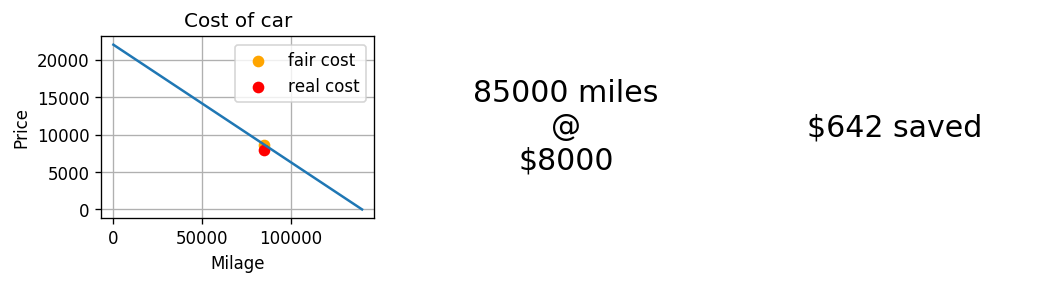

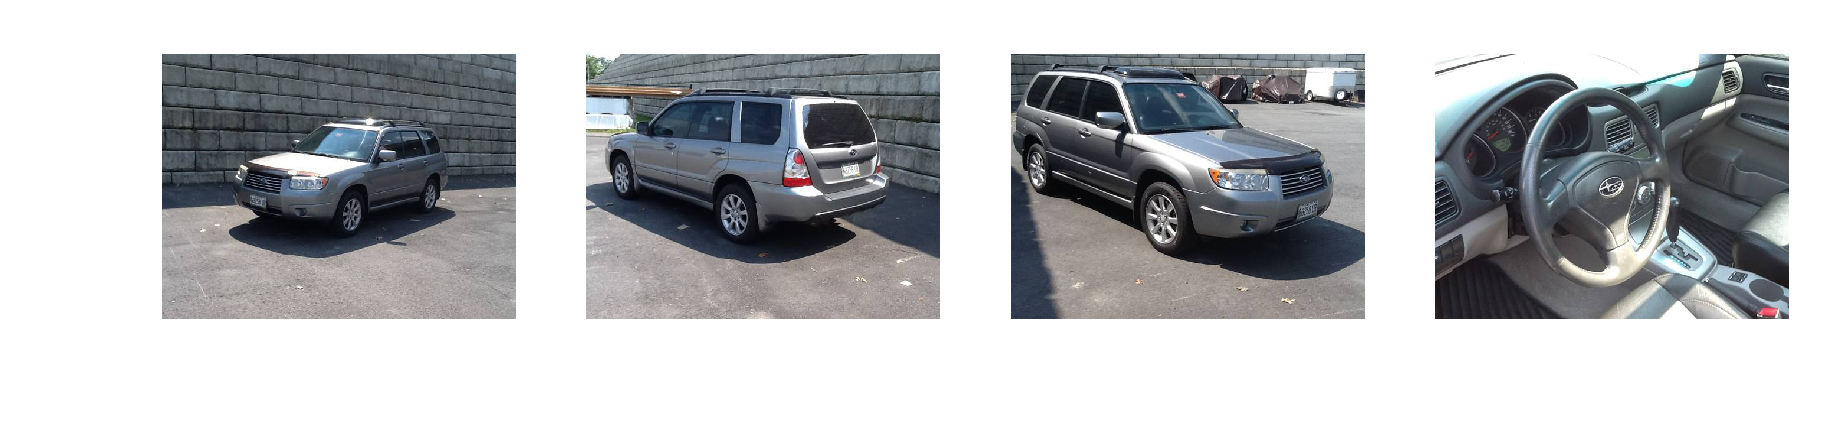

In [195]:
describe('https://boston.craigslist.org/gbs/cto/d/norwood-subaru-forester/7175354467.html', 22_000)